# Import necessary libraries

In [ ]:
!pip install -U scikit-image

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm 
from skimage.transform import resize
from scipy.ndimage import label
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the Dataset

In [2]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)

# Define constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


TRAIN_PATH = 'dataset/train'
TEST_PATH = 'dataset/test'

# Preprocessing

In [3]:
def get_ids(path):
    """Get the IDs of the images in the given path."""
    return next(os.walk(path))[1]

# Train & Test ids
train_ids = get_ids(TRAIN_PATH)
test_ids = get_ids(TEST_PATH)

## Load & Resize Image and mask

In [4]:
def resize_images_and_masks(train_ids):
    X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    print('Resizing training images and masks')
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
        path = os.path.join(TRAIN_PATH, id_)
        img = imread(os.path.join(path, 'images', f'{id_}.png'))[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img
        
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
        for mask_file in next(os.walk(os.path.join(path, 'masks')))[2]:
            mask_ = imread(os.path.join(path, 'masks', mask_file))
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        y[n] = mask
    return X, y

# Resize real image & Mask
X, y = resize_images_and_masks(train_ids)

Resizing training images and masks


100%|██████████| 670/670 [06:57<00:00,  1.61it/s]


In [5]:
def resize_test_images(test_ids):
    test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    
    print('Resizing test images')
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = os.path.join(TEST_PATH, id_)
        img = imread(os.path.join(path, 'images', f'{id_}.png'))[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        test_images[n] = img
    return test_images, sizes_test

# Resize Test image
test_images, sizes_test = resize_test_images(test_ids)

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 40.50it/s]


## Split train and Validations Set

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_validations shape: {X_val.shape}")
print(f"y_validations shape: {y_val.shape}")

print(f"Test image shape: {test_images.shape}")
print(f"Test Size: {len(sizes_test)}")

X_train shape: (448, 128, 128, 3)
y_train shape: (448, 128, 128, 1)
X_validations shape: (222, 128, 128, 3)
y_validations shape: (222, 128, 128, 1)
Test image shape: (65, 128, 128, 3)
Test Size: 65


## Plot the sample real and Mask Image

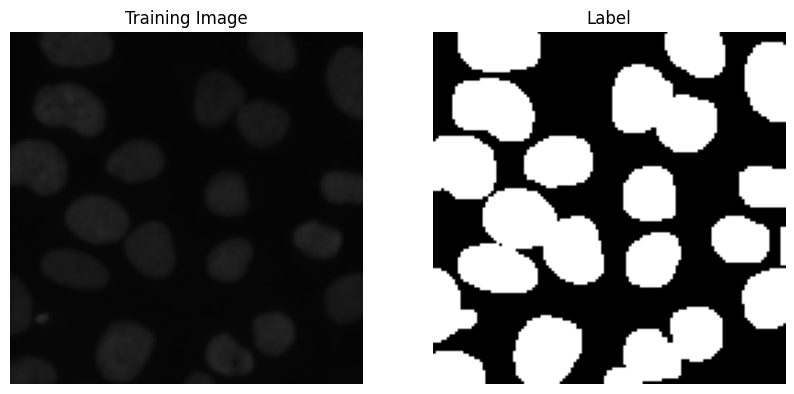

In [7]:
# Choose a random index for the image
image_x = random.randint(0, len(X_train) - 1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10,5))  # 1 row, 2 columns

# Display the training image
axes[0].imshow(np.squeeze(X_train[image_x]), cmap='gray')  # Use squeeze to remove single-dimensional entries
axes[0].axis("off")  # Hide the axis
axes[0].set_title("Training Image")

# Display the corresponding label
axes[1].imshow(np.squeeze(y_train[image_x]), cmap='gray')  # Use squeeze to remove single-dimensional entries
axes[1].axis("off")  # Hide the axis
axes[1].set_title("Label")

# Show the plot
plt.show()

# Build the Unet model

In [35]:
# Define image dimensions and number of channels
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
num_classes = 1

# Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(r4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(r5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_13[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_6[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ re_lu_10[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_7[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ re_lu_11[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_8[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_18[0][0] 

 Total params: 1,400,033 (5.34 MB)

 Trainable params: 1,398,081 (5.33 MB)

 Non-trainable params: 1,952 (7.62 KB)

In [9]:
tf.keras.utils.plot_model(model, "model.png")

AttributeError: module 'pydot' has no attribute 'InvocationException'

# Train the model

## Compile the model

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=16, epochs=35, callbacks=callbacks)

Epoch 1/35


KeyboardInterrupt: 

Epoch 1/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 311ms/step - accuracy: 0.7690 - loss: 0.5583 - val_accuracy: 0.8433 - val_loss: 0.5886
Epoch 2/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.8926 - loss: 0.3087 - val_accuracy: 0.8923 - val_loss: 0.3717
Epoch 3/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 309ms/step - accuracy: 0.9299 - loss: 0.2168 - val_accuracy: 0.9421 - val_loss: 0.2340
Epoch 4/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 312ms/step - accuracy: 0.9348 - loss: 0.1917 - val_accuracy: 0.9452 - val_loss: 0.1924
Epoch 5/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - accuracy: 0.9426 - loss: 0.1645 - val_accuracy: 0.9555 - val_loss: 0.1549
Epoch 6/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 0.9493 - loss: 0.1427 - val_accuracy: 0.9595 - val_loss: 0.1416
Epoch 7/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - accuracy: 0.9494 - loss: 0.1384 - val_accuracy: 0.9608 - val_loss: 0.1232
Epoch 8/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 320ms/step - accuracy: 0.9538 - loss: 0.1276 - val_accuracy: 0

# Model Evaluations

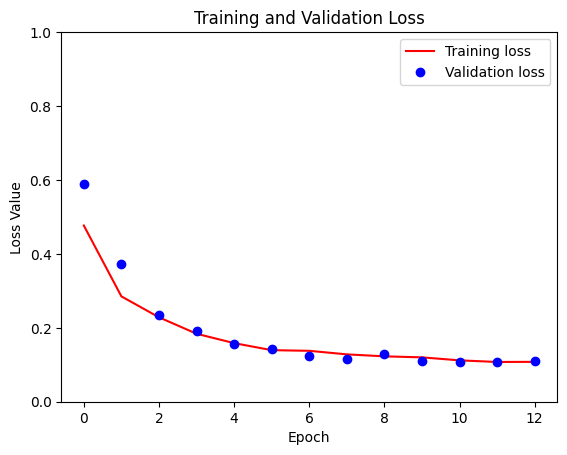

In [12]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

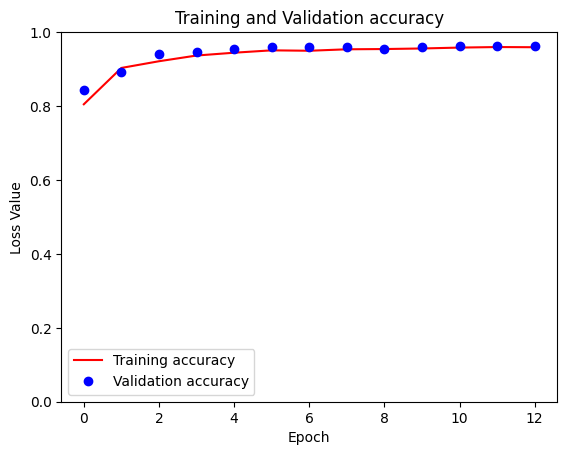

In [13]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure()
plt.plot( accuracy, 'r', label='Training accuracy')
plt.plot( val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Save and Load the model

In [14]:
from keras.models import save_model, load_model

# Save the model
model.save("model.h5")

# Load the model
model = load_model("model.h5")

# Predictions

In [15]:
i = random.randint(0, len(X_val))
sample_image = X_val[i]
sample_mask = y_val[i]

In [16]:
prediction = model.predict(sample_image[tf.newaxis, ...])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


In [17]:
predicted_mask = (prediction > 0.5).astype(np.uint8)

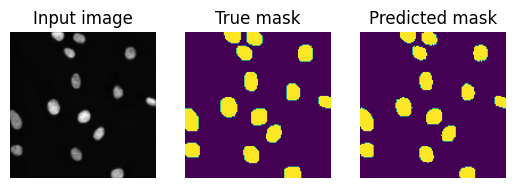

In [18]:
def display(display_list):
    title = ['Input image', 'True mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
display([sample_image, sample_mask,predicted_mask])

# Submission

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


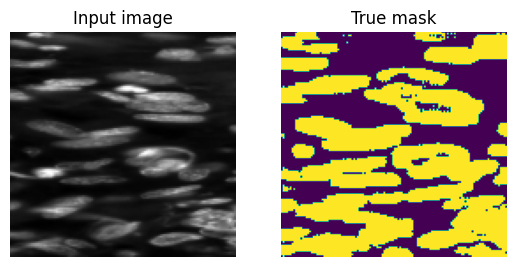

In [31]:
i = random.randint(0, len(test_images))
test_image = test_images[i]

prediction = model.predict(test_image[tf.newaxis, ...])[0]

generated_mask = (prediction > 0.5).astype(np.uint8)

    
display([test_image, generated_mask])